#### Initialize Spark session

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("xor") \
    .config("spark.executor.memory", '2g') \
    .config('spark.executor.cores', '1') \
    .config('spark.cores.max', '1') \
    .config("spark.driver.memory",'1g') \
    .getOrCreate()

sc = spark.sparkContext


#### Read in data and merge dataset on ab_id

In [12]:
pitches = spark.read.option("inferSchema", "true").csv('Data/pitches_update.csv', header = True)
atbats = spark.read.option("inferSchema", "true").csv('Data/atbats.csv', header = True).select("ab_id", "batter_id", 
                                                                                               "inning", "p_score", 
                                                                                               "p_throws", "pitcher_id",
                                                                                               "stand", "top")

df = pitches.join(atbats, "ab_id")

#### Drop unnecessary variables

In [13]:
df = df.drop("ax", "ay", "az", "break_angle", "break_length", "break_y", "code", "event", "g_id",
            
            'nasty', "spin_dir", "end_speed",
             
            "vx0", "vy0", "vz0", "x", "y", "z", "zone", "spin_rate")

In [14]:
df.columns

['ab_id',
 '_c0',
 'b_count',
 'b_score',
 'on_1b',
 'on_2b',
 'on_3b',
 'outs',
 'pfx_x',
 'pfx_z',
 'pitch_num',
 'pitch_type',
 'px',
 'pz',
 's_count',
 'start_speed',
 'sz_bot',
 'sz_top',
 'type',
 'type_confidence',
 'x0',
 'y0',
 'z0',
 'next_pitch',
 'batter_id',
 'inning',
 'p_score',
 'p_throws',
 'pitcher_id',
 'stand',
 'top']

#### Create new variable score_difference

In [15]:
df=df.withColumn("score_difference", df.p_score-df.b_score)

#### Remove low frequency observations (look at pitch_type to decide which ones to remove)

In [16]:
from pyspark.sql.types import StringType, IntegerType, DoubleType
from pyspark.sql.functions import udf
from pyspark.sql import functions as f
from pyspark.sql.functions import col

In [17]:
df = df.filter(
    (col('pitch_type') != 'UN') &
    (col('pitch_type') != 'EP') &
    (col('pitch_type') != 'AB') &
    (col('pitch_type') != 'FA') &
    (col('pitch_type') != 'IN') &
    (col('pitch_type') != 'SC') &
    (col('next_pitch') != 'UN') &
    (col('next_pitch') != 'EP') &
    (col('next_pitch') != 'AB') &
    (col('next_pitch') != 'FA') &
    (col('next_pitch') != 'IN') &
    (col('next_pitch') != 'SC'))

#### FO and PO are the same so consolidate

In [18]:
df=df.na.replace(['FO'], ['PO'], 'pitch_type')
df=df.na.replace(['FO'], ['PO'], 'next_pitch')

#### Create new column that is a latent variable based on pitch_type

In [19]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import CrossValidator

indexer = StringIndexer(inputCol="pitch_type", outputCol="latent_pitch_type")
df = indexer.fit(df).transform(df)
df.head(2)

[Row(ab_id=2015000283.0, _c0=1110, b_count=0.0, b_score=1.0, on_1b=0.0, on_2b=0.0, on_3b=0.0, outs=1.0, pfx_x=6.08, pfx_z=9.83, pitch_num=1.0, pitch_type='FF', px=-0.532, pz=2.702, s_count=0.0, start_speed=93.7, sz_bot=1.86, sz_top=3.83, type='S', type_confidence=2.0, x0=2.161, y0=50.0, z0=6.151, next_pitch='FF', batter_id=120074, inning=1, p_score=0, p_throws='L', pitcher_id=430935, stand='L', top=True, score_difference=-1.0, latent_pitch_type=0.0),
 Row(ab_id=2015000283.0, _c0=1111, b_count=0.0, b_score=1.0, on_1b=0.0, on_2b=0.0, on_3b=0.0, outs=1.0, pfx_x=4.54, pfx_z=12.83, pitch_num=2.0, pitch_type='FF', px=-0.312, pz=2.224, s_count=1.0, start_speed=93.2, sz_bot=1.92, sz_top=3.75, type='S', type_confidence=2.0, x0=2.316, y0=50.0, z0=5.9239999999999995, next_pitch='FF', batter_id=120074, inning=1, p_score=0, p_throws='L', pitcher_id=430935, stand='L', top=True, score_difference=-1.0, latent_pitch_type=0.0)]

In [20]:
indexer = StringIndexer(inputCol="next_pitch", outputCol="latent_next_pitch")
df = indexer.fit(df).transform(df)

In [21]:
df.groupBy("latent_pitch_type").count().show()
df.groupBy("pitch_type").count().show()

+-----------------+------+
|latent_pitch_type| count|
+-----------------+------+
|              8.0| 30932|
|              0.0|763599|
|              7.0| 50315|
|              1.0|330377|
|              4.0|178452|
|              3.0|211756|
|              2.0|244465|
|             10.0|  1165|
|              6.0|109587|
|              5.0|177063|
|              9.0|  8285|
+-----------------+------+

+----------+------+
|pitch_type| count|
+----------+------+
|        FT|244465|
|        SL|330377|
|        FC|109587|
|        FF|763599|
|        FS| 30932|
|        PO|  1165|
|        KC| 50315|
|        CH|211756|
|        CU|178452|
|        KN|  8285|
|        SI|177063|
+----------+------+



In [22]:
df.groupBy("latent_next_pitch").count().show()
df.groupBy("next_pitch").count().show()

+-----------------+------+
|latent_next_pitch| count|
+-----------------+------+
|              8.0| 30932|
|              0.0|763599|
|              7.0| 50315|
|              1.0|330377|
|              4.0|178452|
|              3.0|211756|
|              2.0|244465|
|             10.0|  1165|
|              6.0|109587|
|              5.0|177063|
|              9.0|  8285|
+-----------------+------+

+----------+------+
|next_pitch| count|
+----------+------+
|        FT|244465|
|        SL|330377|
|        FC|109587|
|        FF|763599|
|        FS| 30932|
|        PO|  1165|
|        KC| 50315|
|        CH|211756|
|        CU|178452|
|        KN|  8285|
|        SI|177063|
+----------+------+



#### Create new column that is latent variable based on balls and strikes

In [33]:
def count_status(b_count, s_count):
    if   b_count==0 and s_count==0: return 0
    elif b_count==1 and s_count==0: return 1
    elif b_count==0 and s_count==1: return 2
    elif b_count==1 and s_count==1: return 3
    elif b_count==2 and s_count==0: return 4
    elif b_count==0 and s_count==2: return 5
    elif b_count==3 and s_count==0: return 6
    elif b_count==2 and s_count==1: return 7
    elif b_count==1 and s_count==2: return 8
    elif b_count==3 and s_count==1: return 9
    elif b_count==2 and s_count==2: return 10
    elif b_count==3 and s_count==2: return 11
    
udfcount_status = udf(count_status, IntegerType())
df = df.withColumn("count_status", udfcount_status("b_count", "s_count"))

df = df.na.drop(subset=["count_status"]) #around 14 na's that we drop

#### Create new column that is latent variable based on on_1b, on_2b, and on_3b

In [34]:
def base_status(on_1b, on_2b, on_3b):
    if   on_1b==0 and on_2b==0 and on_3b==0: return 0
    elif on_1b==1 and on_2b==0 and on_3b==0: return 1
    elif on_1b==0 and on_2b==1 and on_3b==0: return 2
    elif on_1b==0 and on_2b==0 and on_3b==1: return 3
    elif on_1b==1 and on_2b==1 and on_3b==0: return 4
    elif on_1b==1 and on_2b==0 and on_3b==1: return 5
    elif on_1b==0 and on_2b==1 and on_3b==1: return 6
    elif on_1b==1 and on_2b==1 and on_3b==1: return 7
    
udfbase_status = udf(base_status, IntegerType())
df = df.withColumn("base_status", udfbase_status("on_1b", "on_2b", "on_3b"))

#### Create new column binning score_difference

In [35]:
def bin_score(score_difference):
    if score_difference<(-4): return (-5)
    elif score_difference>(4): return (5)
    elif score_difference==(-4): return (-4)
    elif score_difference==(-3): return (-3) 
    elif score_difference==(-2): return (-2)
    elif score_difference==(-1): return (-1) 
    elif score_difference==(0): return (0) 
    elif score_difference==(1): return (1)
    elif score_difference==(2): return (2)
    elif score_difference==(3): return (3)
    elif score_difference==(4): return (4)
udfbin_score = udf(bin_score, IntegerType())
df = df.withColumn("binned_score_difference", udfbin_score("score_difference"))

#### Create new column binning pitch_num

In [36]:
def bin_pitch_num(pitch_num):
    if pitch_num>(14.0): 
        return (14.0)
    else: 
        return(pitch_num)
udfpitch_num = udf(bin_pitch_num, DoubleType())
df = df.withColumn("pitch_num", udfpitch_num("pitch_num"))

In [37]:
df.groupby("pitch_num").count().show()

+---------+------+
|pitch_num| count|
+---------+------+
|      8.0|  8796|
|      7.0| 23455|
|      1.0|652101|
|      4.0|268029|
|     11.0|   409|
|     14.0|    32|
|      3.0|405611|
|      2.0|538592|
|     10.0|  1127|
|     13.0|    48|
|      6.0| 59840|
|      5.0|144599|
|      9.0|  3201|
|     12.0|   149|
+---------+------+



In [38]:
def binary_stand(stand):
    if stand == 'R':
        return 1
    else:
        return 0
udfstand = udf(binary_stand, IntegerType())
df = df.withColumn("stand", udfstand("stand"))

In [39]:
df.groupby('stand').count().show()

+-----+-------+
|stand|  count|
+-----+-------+
|    0|2105989|
+-----+-------+



In [42]:
df.groupby('p_throws').count().show()

+--------+-------+
|p_throws|  count|
+--------+-------+
|       0|2105989|
+--------+-------+



In [43]:
def binary_p_throw(p_throw):
    if p_throw == 'R':
        return 1
    else:
        return 0
udfp_throw = udf(binary_p_throw, IntegerType())
df = df.withColumn("p_throws", udfstand("p_throws"))

In [44]:
df.groupby('p_throws').count().show()

+--------+-------+
|p_throws|  count|
+--------+-------+
|       0|2105989|
+--------+-------+



In [45]:
def binary_top(top):
    if top:
        return 1
    else:
        return 0
udfp_top = udf(binary_top, IntegerType())
df = df.withColumn("top", udfstand("top"))

In [ ]:
df.columns

In [85]:
dfpca = df.drop('_c0', 'b_count', 'on_1b', 'on_2b', 'on_3b', 's_count',
               'ab_id',
 'b_score',
 'pfx_x',
 'pfx_z',
 'pitch_type',
 'px',
 'pz',
 'sz_top',
 'type',
 'x0',
 'y0',
 'z0',
                'next_pitch',
 'batter_id',
 'p_score',
 'p_throws',
 'stand',
 'score_difference',
 'latent_pitch_type',
 'latent_next_pitch')

#### Create a pie plot of distribution of pitch_type

In [177]:
import matplotlib.pyplot as plt

pitch_type = df.groupby('pitch_type').count().toPandas()
fig1, ax1 = plt.subplots(figsize=(30,13))
plt.rcParams.update({'font.size': 18})
ax1.pie(pitch_type['count'],labels = pitch_type['pitch_type'], autopct='%1.0f%%', pctdistance=1.1, 
        labeldistance = 1.2, shadow = False, startangle = 90 )
#plt.legend()
plt.legend(labels = ['Two-seam Fastball', 'Slider', 'Cutter', 'Four-seam Fastball', 'Splitter', 'Knuckle Curve',
                     'Changeup', 'Curveball', 'Knuckleball', 'Sinker'])
ax1.axis('equal')
#plt.savefig('init_pie.png')
plt.show()

<Figure size 3000x1300 with 1 Axes>

#### Create a pie plot of distribution of pitch_type of Chris Sale

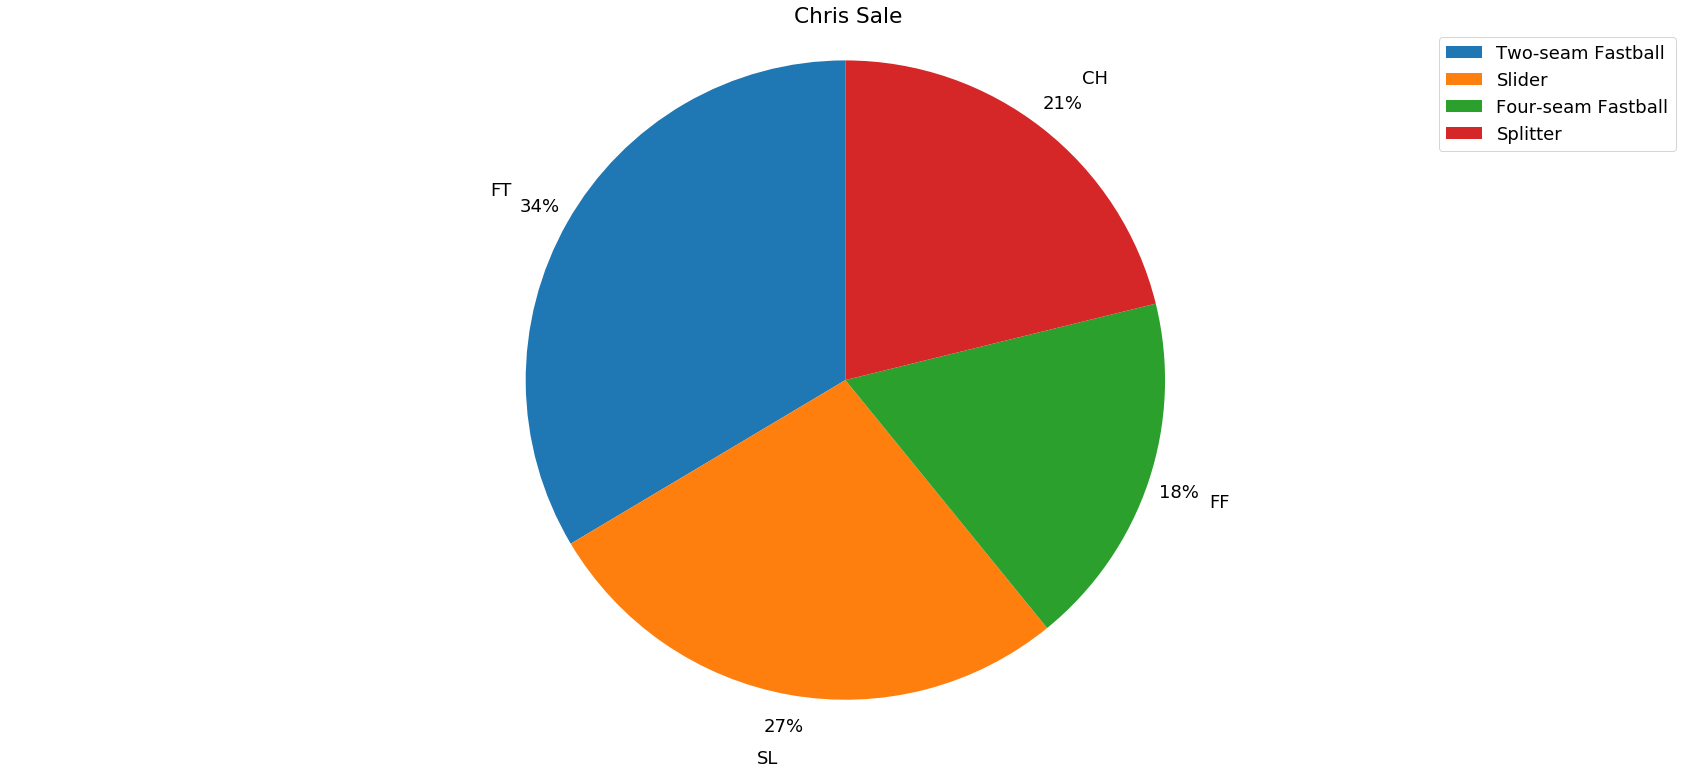

In [178]:
chris_sale = df.filter(df.pitcher_id == 519242).groupby('pitch_type').count().toPandas()
fig2, ax2 = plt.subplots(figsize=(30,13))
plt.rcParams.update({'font.size': 18})
plt.title('Chris Sale')
ax2.pie(chris_sale['count'],labels = chris_sale['pitch_type'], autopct='%1.0f%%', pctdistance=1.1, 
        labeldistance = 1.2, shadow = False, startangle = 90 )
#plt.legend()
plt.legend(labels = ['Two-seam Fastball', 'Slider', 'Four-seam Fastball', 'Splitter',
                     'Changeup'])
ax2.axis('equal')
#plt.savefig('init_pie.png')
plt.show()

In [186]:
chris_sale

,pitch_type,count
0,FT,3140
1,SL,2557
2,FF,1682
3,CH,1980


#### Create a pie plot of distribution of pitch_type of Clayton Kershaw

In [176]:
clay_kersh = df.filter(df.pitcher_id == 477132).groupby('pitch_type').count().toPandas()
fig3, ax3 = plt.subplots(figsize=(30,13))
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'axes.titlepad': 45})
plt.title('Clayton Kershaw',)
ax3.pie(clay_kersh['count'],labels = clay_kersh['pitch_type'], autopct='%1.0f%%', pctdistance=1.1, 
        labeldistance = 1.2, shadow = False, startangle = 90 )
#plt.legend()
plt.legend(labels = ['Two-seam Fastball', 'Slider', 'Four-seam Fastball',
                     'Changeup', 'Curveball'])
ax3.axis('equal')
#plt.savefig('init_pie.png')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
clay_kersh

#### Create new column of vectors of features

In [129]:
pred = ['outs','pitch_num','start_speed','sz_bot',
        'type_confidence','inning','pitcher_id','top',
        'count_status','base_status','binned_score_difference']

In [48]:
df.schema

StructType(List(StructField(ab_id,DoubleType,true),StructField(b_score,DoubleType,true),StructField(outs,DoubleType,true),StructField(pfx_x,DoubleType,true),StructField(pfx_z,DoubleType,true),StructField(pitch_num,DoubleType,true),StructField(pitch_type,StringType,true),StructField(px,DoubleType,true),StructField(pz,DoubleType,true),StructField(start_speed,DoubleType,true),StructField(sz_bot,DoubleType,true),StructField(sz_top,DoubleType,true),StructField(type,StringType,true),StructField(type_confidence,DoubleType,true),StructField(x0,DoubleType,true),StructField(y0,DoubleType,true),StructField(z0,DoubleType,true),StructField(next_pitch,StringType,true),StructField(batter_id,IntegerType,true),StructField(inning,IntegerType,true),StructField(p_score,IntegerType,true),StructField(p_throws,IntegerType,true),StructField(pitcher_id,IntegerType,true),StructField(stand,IntegerType,true),StructField(top,IntegerType,true),StructField(score_difference,DoubleType,true),StructField(latent_pitch_t

In [87]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StandardScaler
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

assembler = VectorAssembler(
                            inputCols=[c for c in dfpca.columns if c in pred],
                            outputCol='features').setHandleInvalid('skip')
output = assembler.transform(dfpca)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=True)
scaleroutput = scaler.fit(output)
scaledoutput = scaleroutput.transform(output)

#### Create PCA model

In [203]:
from  pyspark.sql.functions import abs
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
model = pca.fit(scaledoutput)
matrix=model.pc
rows = matrix.toArray().tolist()
pcadf = spark.createDataFrame(rows,['PCA1','PCA2'])
pcadf = pcadf.withColumn('AbsVal', abs(pcadf.PCA1-pcadf.PCA2))
pcdaf=pcadf.toPandas()
value=spark.createDataFrame(pred, StringType())
value = value.withColumnRenamed('value', 'Feature')
value=value.toPandas()
value

,Feature
0,outs
1,pitch_num
2,start_speed
3,sz_bot
4,type_confidence
5,inning
6,pitcher_id
7,top
8,count_status
9,base_status


In [205]:
pcdaf

,PCA1,PCA2,AbsVal
0,-0.005849,6.446019e-01,6.504507e-01
1,-0.704020,-2.038915e-03,7.019807e-01
2,-0.045313,5.842504e-02,1.037377e-01
3,0.079959,2.771170e-02,5.224682e-02
4,-0.013613,6.627552e-02,7.988868e-02
5,-0.007023,-4.307675e-02,3.605352e-02
6,-0.016352,1.391299e-01,1.554821e-01
7,0.000000,8.673617e-19,8.673617e-19
8,-0.703798,-2.704399e-03,7.010938e-01
9,0.002536,6.577610e-01,6.552248e-01


In [149]:
pcamax = PCA(k=10, inputCol="scaledFeatures", outputCol="pcaFeatures")
modelmax = pcamax.fit(scaledoutput)

In [206]:
Explained_Var = modelmax.explainedVariance
a = Explained_Var.values.tolist()
valuetwo=spark.createDataFrame(a, DoubleType())
valuetwo=valuetwo.toPandas()
valuetwo

,value
0,0.196426
1,0.125384
2,0.121597
3,0.107273
4,0.101885
5,0.093965
6,0.091099
7,0.080123
8,0.077809
9,0.004439


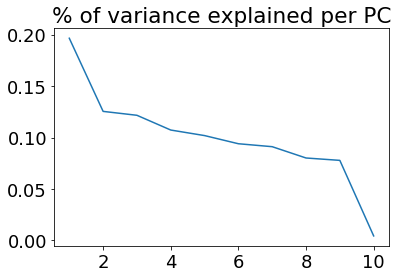

In [196]:
plt.plot([1,2,3,4,5,6,7,8,9,10], valuetwo)
plt.title('% of variance explained per PC')

plt.show()

In [122]:
df.columns

['ab_id',
 'b_score',
 'outs',
 'pfx_x',
 'pfx_z',
 'pitch_num',
 'pitch_type',
 'px',
 'pz',
 'start_speed',
 'sz_bot',
 'sz_top',
 'type',
 'type_confidence',
 'x0',
 'y0',
 'z0',
 'next_pitch',
 'inning',
 'p_score',
 'p_throws',
 'pitcher_id',
 'stand',
 'top',
 'score_difference',
 'latent_pitch_type',
 'count_status',
 'base_status',
 'binned_score_difference',
 'latent_next_pitch']

In [200]:
df = df.drop('ab_id', 'b_score', 'pitch_type', 'type', 'type_confidence', 'next_pitch', 'p_score')

In [201]:
df.columns

['outs',
 'pfx_x',
 'pfx_z',
 'pitch_num',
 'px',
 'pz',
 'start_speed',
 'sz_bot',
 'sz_top',
 'x0',
 'y0',
 'z0',
 'batter_id',
 'inning',
 'p_throws',
 'pitcher_id',
 'stand',
 'top',
 'score_difference',
 'latent_pitch_type',
 'latent_next_pitch',
 'count_status',
 'base_status',
 'binned_score_difference']

In [202]:
df.toPandas().to_csv('pitches_preprocessed.csv')